In [ ]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pygeos
import geopandas as gpd
import contextily as cx
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy import interpolate
import seaborn as sns
import pyproj
import pygeos
from mpl_toolkits.axes_grid1 import make_axes_locatable

# path to python scripts
sys.path.append(os.path.join('..','src','trails'))

from population_OD import *

#from network import *

In [2]:
# set data paths to results
data_random_attack = r'C:\Data\Global_Percolation\percolation_results_random_attack_regular'
data_targeted_attack = r'C:\Data\Global_Percolation\percolation_results_targeted_attack'
data_local_attack_05 = r'C:\Data\Global_Percolation\percolation_results_local_attack_05'
data_local_attack_01 = r'C:\Data\Global_Percolation\percolation_results_local_attack_01'
data_local_attack_005 = r'C:\Data\Global_Percolation\percolation_results_local_attack_005'

data_path_met= r'C:\Data\Global_Percolation\percolation_metrics'
data_path_net = r'C:\Data\Global_Percolation\percolation_networks'
data_path_grids = r'C:\Data\Global_Percolation\percolation_grids'

# file to get full country names
glob_info = pd.read_excel(r'C:\Projects\trails\data\global_information.xlsx')
gdp_cap_country = pd.read_csv(r'C:\Projects\trails\data\percolation\worldbank_gdp_2019.csv',sep=';')
income_groups = pd.read_excel(r'C:\Projects\trails\data\percolation\CLASS.xls',sheet_name='Groups')

# get all files from data paths
perc_files = os.listdir(data_random_attack)
perc_files_targeted_attack = os.listdir(data_targeted_attack)
perc_files_local_attack_05 = os.listdir(data_local_attack_05)
perc_files_local_attack_01 = os.listdir(data_local_attack_01)
perc_files_local_attack_005 = os.listdir(data_local_attack_005)

grid_files = os.listdir(data_path_grids)

met_files = os.listdir(data_path_met)
net_files = os.listdir(data_path_net)

In [3]:
continent_dict = dict(zip(glob_info['ISO_3digit'],glob_info['continent']))

In [4]:
%%time
gadm36 = gpd.read_file(r'C:/Data/Global_Geospatial/GADM/gadm36_levels.gpkg',layer=0)
py_geoms = pygeos.from_shapely(gadm36.geometry.values)
gadm36.geometry = py_geoms

Wall time: 16.5 s


In [5]:
%%time
gadm36 = gadm36.loc[gadm36.GID_0.isin(glob_info.ISO_3digit.values)]
gadm36['continent'] = gadm36.GID_0.apply(lambda x: continent_dict[x])

Wall time: 7 ms


In [6]:
%%time
gadm36 = pd.DataFrame(gadm36.copy()) #.loc[gadm36.continent == 'South-America']
gadm36.geometry = pygeos.make_valid(pygeos.from_shapely(gadm36.geometry))

Wall time: 1min 12s


In [7]:
gadm36.geometry = pygeos.simplify(gadm36.geometry,tolerance=0.1,preserve_topology=True)

In [8]:
%%time
make_parts = pygeos.get_parts(gadm36.geometry.values)
make_multi = pygeos.multipolygons(make_parts)

Wall time: 92.7 ms


In [9]:
%%time
global_shape = pygeos.buffer(make_multi,0.1)

Wall time: 33min 31s


In [10]:
%%time
grid = create_grid(create_bbox(pd.DataFrame([global_shape],columns=['geometry'])),0.5)
pygeos.prepare(grid)

Wall time: 1.11 s


In [11]:
tqdm.pandas()

grid = pd.DataFrame(grid,columns=['geometry'])

clip_grid = grid.geometry.progress_apply(lambda x: pygeos.intersection(x,global_shape))

grid.geometry = clip_grid
grid = grid.loc[~pygeos.is_empty(grid.geometry)]
grid.reset_index(drop=True,inplace=True)

100%|████████████████████████████████████████████████████████████████████████| 206927/206927 [1:09:57<00:00, 49.30it/s]


In [ ]:
country_grids = {}

for country in tqdm(glob_info.ISO_3digit.values,total=len(glob_info.ISO_3digit.values)):

    network = 0
    #specify file
    # if glob_info.loc[glob_info.ISO_3digit == country].continent.values[0] != 'Europe':
    #     continue
    file = '{}_{}_results.csv'.format(country,network)
        
    # 0.5 degree
    try:
        df_local_05 = pd.read_csv(os.path.join(data_local_attack_05,file),index_col=[0])
        grid_05 = pd.read_csv(os.path.join(data_path_grids,'{}_{}_05.csv'.format(country,network)))
        grid_05 = grid_05.rename(columns={"Unnamed: 0": "grid_no"})
        grid_05 = gpd.GeoDataFrame(grid_05.join(df_local_05[['grid_no','pct_isolated','pct_delayed']].set_index('grid_no'),on='grid_no').fillna(0))
        grid_05.geometry = pygeos.from_wkt(grid_05.geometry) 
        
        country_grids[country] = grid_05
    except:
        None

In [ ]:
grid_data = pd.concat(country_grids)[['geometry','urban','pct_isolated','pct_delayed']].reset_index()

In [ ]:
tree = pygeos.STRtree(pygeos.centroid(pygeos.from_shapely(grid_data.geometry)))

In [ ]:
collect_data = []
for grid_cell in tqdm(grid.iterrows(),total=len(grid)):
    get_data = list(grid_data.loc[tree.query(grid_cell[1].values[0])][['pct_isolated','pct_delayed']].values)

    if len(get_data) == 0:
        collect_data.append([grid_cell[0]]+[0,0])
    elif len(get_data) > 1:
        collect_data.append([grid_cell[0]]+[max([x[0] for x in get_data]),max([x[1] for x in get_data])])
    else:
        collect_data.append([grid_cell[0]]+[max([x[0] for x in get_data]),max([x[1] for x in get_data])])
#africa_grid.progress_apply(lambda x: print(x.Name),axis=1) #africa_data.loc[tree.query(africa_grid.iloc[x.Name]['geometry'])][['urban','pct_isolated','pct_delayed']].values,axis=1)

In [ ]:
grid_info = pd.DataFrame(collect_data,columns=['grid_no','pct_isolated','pct_delayed'])

In [12]:
#grid_info.to_csv('C://Projects//trails//results//degree005_results.csv')
grid_info = pd.read_csv('C://Projects//trails//results//degree005_results.csv',index_col=[0])

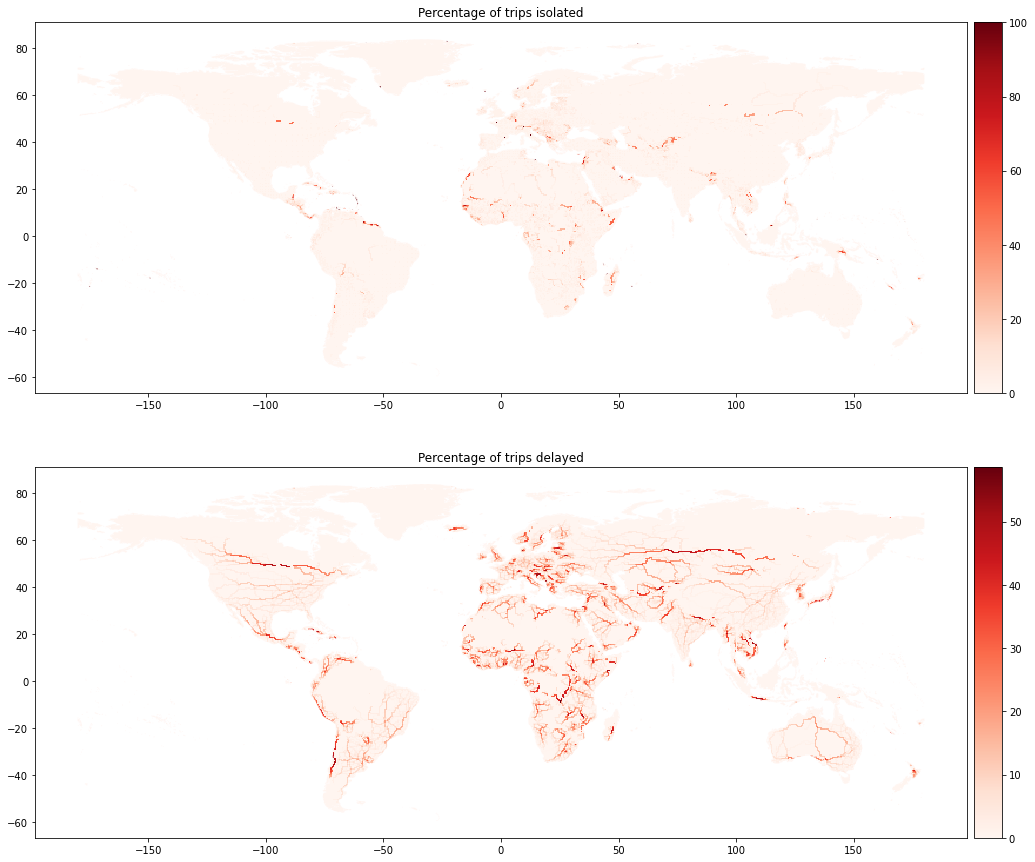

In [13]:
fig, axs = plt.subplots(2,1,figsize=(20,15))

for iter_,ax in enumerate(axs.flatten()):

    if iter_ == 0:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)         
        gpd.GeoDataFrame(grid.join(grid_info.set_index('grid_no'),how='left')).plot(column='pct_isolated',cmap='Reds',ax=ax,cax=cax,legend=True)
        ax.set_title('Percentage of trips isolated')

    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)  
        gpd.GeoDataFrame(grid.join(grid_info.set_index('grid_no'),how='left')).plot(column='pct_delayed',cmap='Reds',ax=ax,cax=cax,legend=True)
        ax.set_title('Percentage of trips delayed')
        
fig.savefig('../figures/loc05_globalgrid.png')

In [26]:
df = gpd.GeoDataFrame(grid.join(grid_info.set_index('grid_no'),how='left'))#.plot(column='pct_isolated',cmap='Reds',ax=ax,cax=cax,legend=True)
df = df.set_crs(4326)

In [33]:
df.to_file(os.path.join('..','figures','degree05_isolated_disrupted.gpkg'),driver='GPKG')

In [53]:
ne_coastlines = gpd.read_file('C:\\Data\\natural_earth\\ne_10m_coastline.shp')

In [ ]:
# Define the CartoPy CRS object.
crs = ccrs.Mollweide()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init

df_epsg = df.iloc[100:].iloc[:-100].to_crs(crs_proj4)
ne_coastlines = ne_coastlines.to_crs(crs_proj4)

In [1]:
# Generate a figure with two axes, one for CartoPy, one for GeoPandas
fig, axs = plt.subplots(2, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(20, 10))

# Make the isolated plot
df_epsg.plot(column='max_pct_trips_isolated',ax=axs[0], cmap='Reds',linewidth=0,vmax=100)
ne_coastlines.plot(ax=axs[0],edgecolor='black',linewidth = 0.5)

# Make the delayed plot
df_epsg.plot(column='max_pct_trips_delayed',ax=axs[1], cmap='Reds',linewidth=0,vmax=100)
ne_coastlines.plot(ax=axs[1],edgecolor='black',linewidth = 0.5)

fig.savefig(os.path.join('..','figures','degree05_isolated_disrupted.svg'))

NameError: name 'plt' is not defined